<a href="https://colab.research.google.com/github/Vejber/nn-zero-to-hero/blob/master/homeworks/hw2_poems/gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Запуск без изменений, с датасетом стихов на русском:

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from urllib import request
import pandas as pd

# hyperparameters
batch_size = 64  # how many independent sequences will we process in parallel?
block_size = 256  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with request.urlopen('https://raw.githubusercontent.com/Vejber/nn-zero-to-hero/master/homeworks/hw2_poems/poems.txt') as f:
    text = f.read().decode()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
# encoder: take a string, output a list of integers
def encode(s): return [stoi[c] for c in s]
# decoder: take a list of integers, output a string
def decode(l): return ''.join([itos[i] for i in l])


# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))  # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B, T, C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x)  # (B,T,hs)
        # compute attention scores ("affinities")
        # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(
            self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if iter == max_iters - 1:
            # Создаем DataFrame с первой строкой данных
            df = pd.DataFrame({'perplexity_train': [torch.exp(losses['train'])], 'perplexity_val': [torch.exp(losses['val'])]})
            print(df)
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

10.854294 M parameters
step 0: train loss 5.2275, val loss 5.2390
step 500: train loss 2.0231, val loss 2.0690
step 1000: train loss 1.6376, val loss 1.8169
step 1500: train loss 1.4485, val loss 1.7095
step 2000: train loss 1.3059, val loss 1.6349
step 2500: train loss 1.2061, val loss 1.6360
step 3000: train loss 1.1147, val loss 1.6518
step 3500: train loss 1.0338, val loss 1.6756
step 4000: train loss 0.9447, val loss 1.7275
step 4500: train loss 0.8607, val loss 1.7809
step 4999: train loss 0.7832, val loss 1.8389
  perplexity_train  perplexity_val
0   tensor(2.1885)  tensor(6.2898)

не с клоней волной —
   На воротах.
 
   Я здесь молчала и течет… волей,
   Ты тень услыхаешь моем.
 
   – Вы ли тебя улыбку первый луж,
   Во рта ветворенском, —
   Сердце Ты темна. Споряют, сердце мое, подружка!
 
 
   Царь и напоризна корет,
   Сказал бы мого и грусть, – оторвая твоему.
   Ты знала, последий мой, один ружь!
   Ты хороша, Ревностью не выйду!
 
   Ты смелаешь родиной чьей ногою
   – 

In [ ]:
# print perplexity
print(df)

   perplexity_train  perplexity_val
0            2.1885          6.2898


Ниже изменены параметры: функция активации (ELU), 8 layers, dff = 4608, H = 18.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from urllib import request
import pandas as pd

# hyperparameters
batch_size = 64  # how many independent sequences will we process in parallel?
block_size = 256  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384

# changed block
n_head = 18
n_layer = 8
n_dff = 4608
# changed block end

dropout = 0.2
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with request.urlopen('https://raw.githubusercontent.com/Vejber/nn-zero-to-hero/master/homeworks/hw2_poems/poems.txt') as f:
    text = f.read().decode()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
# encoder: take a string, output a list of integers
def encode(s): return [stoi[c] for c in s]
# decoder: take a list of integers, output a string
def decode(l): return ''.join([itos[i] for i in l])


# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))  # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B, T, C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x)  # (B,T,hs)
        # compute attention scores ("affinities")
        # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(
            self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, n_dff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_dff),
            # new activation function:
            nn.ELU(),
            nn.Linear(n_dff, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd, n_dff)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

perplexity_log = f'perplexity_train,perplexity_val\n'

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if iter == max_iters - 1:
          # Создаем DataFrame с первой строкой данных
            data = pd.DataFrame({'perplexity_train': [torch.exp(losses['train'])], 'perplexity_val': [torch.exp(losses['val'])]})
            print(data)
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

33.226134 M parameters
step 0: train loss 5.0906, val loss 5.0890
step 500: train loss 2.2227, val loss 2.2511
step 1000: train loss 1.9366, val loss 2.0095
step 1500: train loss 1.8086, val loss 1.9247
step 2000: train loss 1.7191, val loss 1.8630
step 2500: train loss 1.6441, val loss 1.8239
step 3000: train loss 1.5691, val loss 1.7781
step 3500: train loss 1.5037, val loss 1.7312
step 4000: train loss 1.4377, val loss 1.7049
step 4500: train loss 1.3806, val loss 1.6754
step 4999: train loss 1.3291, val loss 1.6602
  perplexity_train  perplexity_val
0   tensor(3.7776)  tensor(5.2602)

   Кивает не завеслый дножа
   Одинскими, вселенными далёкся,
   Стрекая говор ега!
 
   10 октября 1919
“Даль И Когда Страши…”
   Да, когда страшива, к земную —
   Воркому пролять еще.
   Под рекою больботы.
   Мнё – колений!
 
   Улыбельно одыши его
   Бурь нам нежена,
   Не видем, а нежной один —
   От нежно я,
   В верике пир и от ведь!
 
   Уж и на гробу ваших не отвечных,
   В паритете?.. Жених 

Сравнение значений perplexity до и после изменений параметров и функции активации

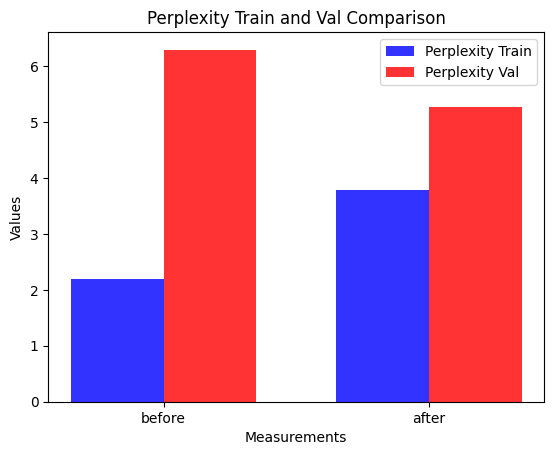

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Чтение данных из CSV файла
file_path = '/content/perplexity.csv'
data = pd.read_csv(file_path, delimiter=';', decimal=',')

# Создание столбчатой диаграммы
fig, ax = plt.subplots()
index = [0, 1]
bar_width = 0.35
opacity = 0.8

# Получение значений
perplexity_train_values = data['perplexity_train']
perplexity_val_values = data['perplexity_val']

# Расчет позиций для столбцов
train_positions = [x - bar_width/2 for x in index]
val_positions = [x + bar_width/2 for x in index]

# Рисование столбцов
rects1 = ax.bar(train_positions, perplexity_train_values, bar_width, alpha=opacity, color='b', label='Perplexity Train')
rects2 = ax.bar(val_positions, perplexity_val_values, bar_width, alpha=opacity, color='r', label='Perplexity Val')

# Настройка осей
ax.set_xlabel('Measurements')
ax.set_ylabel('Values')
ax.set_title('Perplexity Train and Val Comparison')
ax.set_xticks(index)
ax.set_xticklabels(['before', 'after'])
ax.legend()

plt.show()
